In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5" #! specify gpu here

# import matplotlib
import matplotlib.pyplot as plt

import datetime
import seaborn as sns
import json
import warnings
from pathlib import Path
import random
import base64
from io import BytesIO
import cv2
import vision_pipeline.obb
import imagesize
import skimage
# from scipy import ndimage
import natsort
from PIL import Image as PILImage
from PIL import ImageDraw, ImageFilter
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from rich import print
from types import SimpleNamespace
import pickle
import imutils

# ros package
from context_action_framework.types import Detection, Label, Module, Camera
from sensor_msgs.msg import Image, CameraInfo # CameraInfo needed for pickle
# local imports
from vision_pipeline.helpers import Struct, make_valid_poly, img_to_camera_coords, scale_img, add_angles, load_depth_data_from_filename
from context_action_framework.graph_relations import GraphRelations, exists_detection, compute_iou
from vision_pipeline.work_surface_detection_opencv import WorkSurfaceDetection
from vision_pipeline.object_detection_model import ObjectDetectionModel
from vision_pipeline.object_detection import ObjectDetection
from vision_pipeline.object_reid import ObjectReId

from vision_pipeline.config import load_config

from vision_pipeline.object_reid_superglue import ObjectReIdSuperGlue


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
config = load_config(os.path.expanduser("~/vision_pipeline/config.yaml"))

config.reid = False
config.obj_detection.rotation_median_filter = False #! WE SHOULD CHECK THIS ALSO WITH TRUE.

###################################
# camera_type = Camera.basler
# camera_config = config.basler
###################################
camera_type = Camera.realsense
camera_config = config.realsense
###################################

camera_name = camera_type.name


if camera_type == Camera.basler:
    camera_config.enable_topic = "set_sleeping" # basler camera specific
    camera_config.enable_camera_invert = True # enable = True, but the topic is called set_sleeping, so the inverse
    camera_config.use_worksurface_detection = True
elif camera_type == Camera.realsense:
    camera_config.enable_topic = "enable" # realsense specific
    
    depth_rescaling_factor = 1/1000 # scale depth from mm to meters

model = ObjectDetectionModel(config.obj_detection)

object_detection = ObjectDetection(config, 
                                    camera_config,
                                    model=model,
                                    object_reid=None,
                                    camera=camera_type,
                                    frame_id="",
                                    use_ros=False)

config:
{
    'node_name': 'vision',
    'reid': False,
    'basler': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 180,
        'topic': 'basler',
        'camera_node': '/basler',
        'image_topic': 'image_rect_color',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_graph_img': True,
        'has_depth': False,
        'run_continuous': False,
        'wait_for_services': False,
        'detect_arucos': False,
        'table_name': 'table_vision',
        'parent_frame': 'vision_table_zero',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'work_surface_ignore_border_width': 50,
        'show_work_surface_detection': False,
        'use_worksurface_detection': True,
        'debug_work_surface_detection': False
    },
    'realsense': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 0,
        'topic': 'realsense',
        'camera_node': '/realsense',
        'image_topic': 'color/image_raw',
        'info_topic': 'color/camera_info',
        'depth_topic': 'aligned_depth_to_color/image_raw',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_depth_img': True,
        'publish_cluster_img': True,
        'publish_graph_img': False,
        'has_depth': True,
        'compute_gaps': False,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'camera_height': 0.2,
        'parent_frame': 'panda_2/realsense',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'calibration_file': '~/vision_pipeline/realsense_calib/realsense_calib.yaml',
        'debug_clustering': False
    },
    'obj_detection': {
        'debug': True,
        'model': 'yolov8',
        'yolact_dataset_file': '~/vision_pipeline/data_limited/yolact/2023-07-18_firealarms_hcas/dataset.json',
        'yolact_score_threshold': 0.5,
        'yolov8_model_file': 
'~/vision_pipeline/data_limited/yolov8/output_2024-07-17_20000_incl_new_jsi_imgs_p2/epoch60.pt',
        'yolov8_score_threshold': 0.5,
        'superglue_templates': '~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped',
        'superglue_model_file': 
'~/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt',
        'superglue_match_threshold': 0.5,
        'rotation_median_filter': False,
        'superglue_visualise_to_file': False,
        'classifier_model_file': 
'~/vision_pipeline/data_limited/classifier/2024-07-19__14-32_classify/lightning_logs/version_0/checkpoints/epoch=33
9-step=339.ckpt',
        'classifier_threshold': 0.2
    }
}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.learning_rate 1e-05

model.batch_size 64

model.freeze_backbone False

curr_weights_path 
/home/docker/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt

Loaded SuperPoint model
Loaded SuperGlue model ("/home/docker/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt" weights)


100%|██████████| 61/61 [00:00<00:00, 179.06it/s]


Loaded superglue templates 61

In [3]:
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-02-20_hca_backs_UNLABELED/hca_0/0001.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_09/0333.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_15/0792.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_12/0588.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2024-01-02_14:27:09_basler/0004.jpg")
# img_path = os.path.expanduser("~/vision_pipeline/saves/2024-01-04_14:22:15_basler/0012.jpg")

# base_path = Path("~/datasets2/reconcycle/2024-07-10_jsi_devices/2024-07-12_basler_firealarms/").expanduser()
# base_path = Path("~/datasets2/reconcycle/2024-07-10_jsi_devices/2024-07-12_realsense_firealarms/").expanduser()

base_path = Path("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted").expanduser()
# base_path = Path("~/datasets2/reconcycle/2024-07-24_realsense_fire_alarms").expanduser()
# base_path = Path("~/datasets2/reconcycle/2024-04-30_realsense_hcas").expanduser()
img_paths = list(base_path.glob("*.jpg")) + list(base_path.glob("*.png"))
img_paths = [img_path for img_path in img_paths if "depth" not in img_path.name]
img_paths = natsort.os_sorted(img_paths)

# img_paths = [img_paths[0]] #!DEBUG
img_paths = [ base_path / Path("firealarm_back_03.1/0179.jpg")] #!DEBUG

#! 7 is broken

In [12]:


base_path = Path("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted").expanduser()

subfolders = [f for f in base_path.glob('*/') if f.is_dir()]
# subfolders = [f for f in subfolders if "firealarm_front" in f.name or "firealarm_back" in f.name]
subfolders = [f for f in subfolders if "hca_front" in f.name or "hca_back" in f.name]

# print("subfolders", subfolders)

subset_imgs = []
for subfolder in subfolders:
    _img_paths = list(subfolder.glob("*.jpg")) + list(subfolder.glob("*.png"))
    _img_paths = [img_path for img_path in _img_paths if "depth" not in img_path.name]
    _img_paths = natsort.os_sorted(_img_paths)
    # print("_img_paths", _img_paths)
    if len(_img_paths) > 3:
        img_path = _img_paths[3] # get 3rd image.
        subset_imgs.append(img_path)
        img_path = _img_paths[-1] # get last image.
        subset_imgs.append(img_path)

print("subset_imgs", subset_imgs)

img_paths = subset_imgs



subset_imgs
[
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_01/0143.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_01/0150.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_01.1/0239.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_01.1/0245.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_01/hca_1_00002.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_01/hca_11_00042.png')
,
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_05/0099.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_05/0113.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_11/hca_7_00002.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_11/hca_7_00034.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_13/hca_10_00002.png')
,
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_13/hca_10_00027.png')
,
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_10/hca_6_00002.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_10/hca_6_00027.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_11.1/hca_13_00002.png
'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_11.1/hca_13_00033.png
'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_06/hca_4_00002.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_06/hca_4_00029.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_13/0035.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_13/0071.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_07/0167.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_07/0250.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_03/hca_0_00002.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_03/hca_0_00120.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_02/0196.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_02/0204.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_11.1/0116.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_11.1/0130.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_04/hca_3_00002.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_04/hca_3_00022.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_10/0046.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_10/0060.jpg'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_12/hca_9_00002.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_front_12/hca_9_00038.png'),
    PosixPath('/home/docker/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/hca_back_04.1/0229.jpg'),
    PosixPath('/home/docker/datasets2/

making folder /home/docker/vision_pipeline/saves/2024-08-15_08:35:26_test_pipeline_integrated

running worksurface detection...

classify: kalo2, 01, conf: 0.99

elapsed_time_classify_and_rot 0.021103885024785995

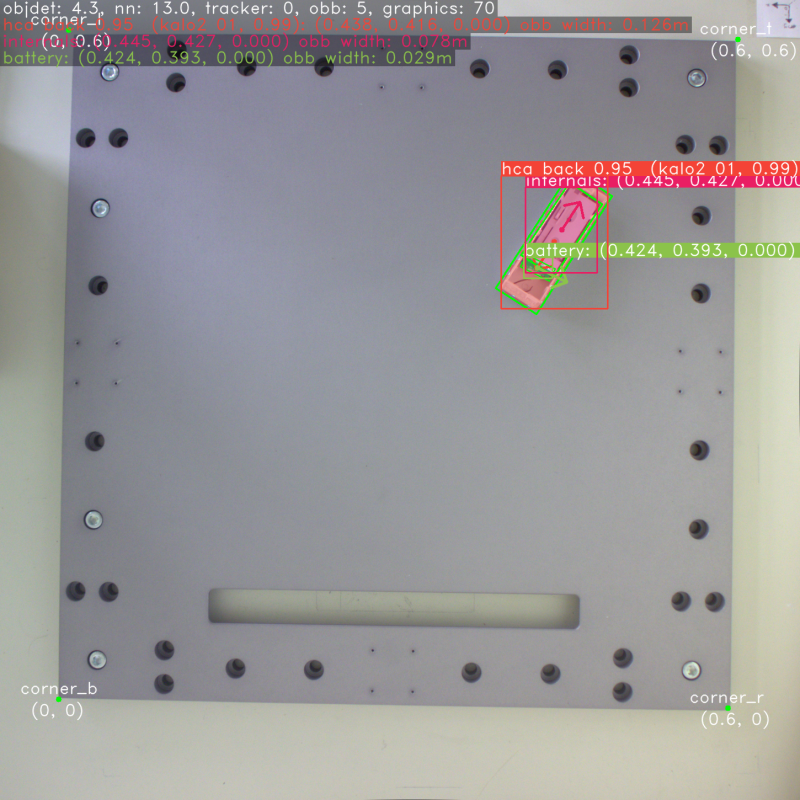

running worksurface detection...

classify: kalo2, 01, conf: 0.99

elapsed_time_classify_and_rot 0.0184000376611948

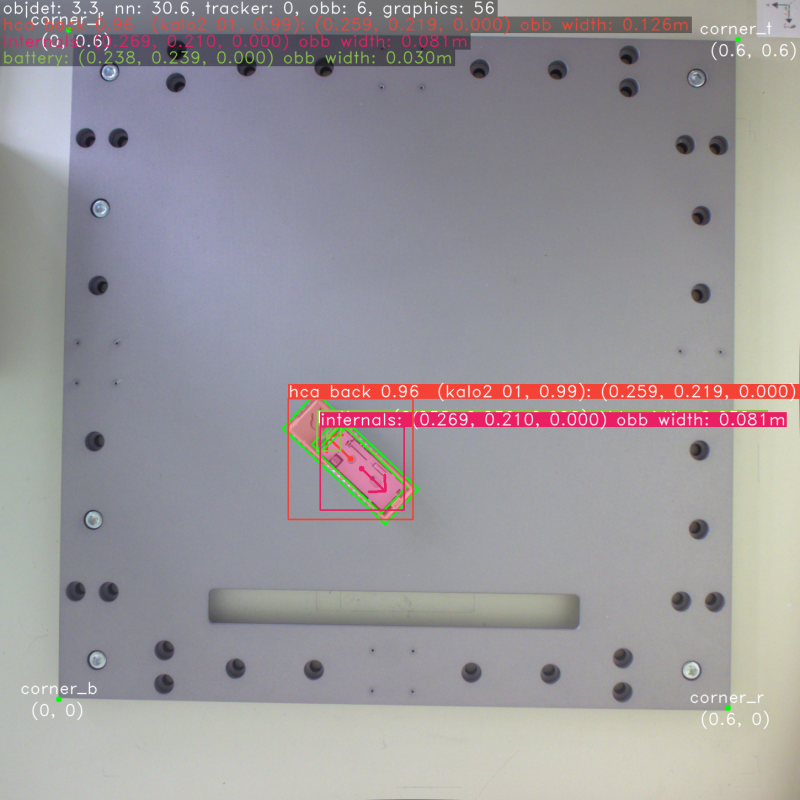

running worksurface detection...

classify: kalo2, 01.1, conf: 0.90

elapsed_time_classify_and_rot 0.018263259902596474

running worksurface detection...

classify: kalo2, 01.1, conf: 0.76

elapsed_time_classify_and_rot 0.018695998936891556

running worksurface detection...

classify: kalo2, 01, conf: 0.99

elapsed_time_classify_and_rot 0.017540616914629936

running worksurface detection...

classify: kalo2, 01, conf: 0.99

elapsed_time_classify_and_rot 0.017623700201511383

running worksurface detection...

classify: ecotron, 05, conf: 0.98

elapsed_time_classify_and_rot 0.018218500539660454

running worksurface detection...

classify: ecotron, 05, conf: 0.97

elapsed_time_classify_and_rot 0.018257537856698036

running worksurface detection...

classify: enco, 11, conf: 0.99

elapsed_time_classify_and_rot 0.018374906852841377

running worksurface detection...

classify: enco, 11, conf: 0.98

elapsed_time_classify_and_rot 0.01918850839138031

running worksurface detection...

classify: qundis2, 13, conf: 1.00

elapsed_time_classify_and_rot 0.019043920561671257

running worksurface detection...

classify: qundis2, 13, conf: 0.99

elapsed_time_classify_and_rot 0.017699049785733223

running worksurface detection...

classify: qundis, 10, conf: 0.99

elapsed_time_classify_and_rot 0.0178404301404953

running worksurface detection...

classify: qundis, 10, conf: 1.00

elapsed_time_classify_and_rot 0.017584608867764473

running worksurface detection...

classify: enco, 11.1, conf: 0.99

elapsed_time_classify_and_rot 0.018472183495759964

running worksurface detection...

classify: enco, 11.1, conf: 1.00

elapsed_time_classify_and_rot 0.017938140779733658

running worksurface detection...

classify: heimer, 06, conf: 0.98

elapsed_time_classify_and_rot 0.017761465162038803

running worksurface detection...

classify: heimer, 06, conf: 0.99

elapsed_time_classify_and_rot 0.020749162882566452

running worksurface detection...

classify: qundis2, 13, conf: 0.99

elapsed_time_classify_and_rot 0.022083377465605736

running worksurface detection...

classify: qundis2, 13, conf: 0.99

elapsed_time_classify_and_rot 0.018718233332037926

running worksurface detection...

classify: caloric, 07, conf: 0.99

elapsed_time_classify_and_rot 0.018354997038841248

running worksurface detection...

classify: caloric, 07, conf: 0.98

elapsed_time_classify_and_rot 0.01808626763522625

running worksurface detection...

classify: kalo, 03, conf: 1.00

elapsed_time_classify_and_rot 0.018073664978146553

running worksurface detection...

classify: kalo, 03, conf: 1.00

elapsed_time_classify_and_rot 0.017842063680291176

running worksurface detection...

classify: minol, 02, conf: 0.92

elapsed_time_classify_and_rot 0.018641432747244835

running worksurface detection...

classify: minol, 02, conf: 0.98

elapsed_time_classify_and_rot 0.018132096156477928

running worksurface detection...

classify: enco, 11.1, conf: 0.99

elapsed_time_classify_and_rot 0.01809839718043804

running worksurface detection...

classify: enco, 11.1, conf: 0.98

elapsed_time_classify_and_rot 0.020208045840263367

running worksurface detection...

classify: techem, 04, conf: 0.99

elapsed_time_classify_and_rot 0.020917238667607307

running worksurface detection...

classify: techem, 04, conf: 0.99

elapsed_time_classify_and_rot 0.01851251721382141

running worksurface detection...

classify: qundis, 10, conf: 0.99

elapsed_time_classify_and_rot 0.018187733367085457

detection: NOT A SCREW plastic_clip invalid: edge too small: 0.008m

running worksurface detection...

classify: qundis, 10, conf: 0.99

elapsed_time_classify_and_rot 0.01843918301165104

running worksurface detection...

classify: kundo, 12, conf: 0.99

elapsed_time_classify_and_rot 0.018370866775512695

running worksurface detection...

classify: kundo, 12, conf: 0.97

elapsed_time_classify_and_rot 0.018538936972618103

running worksurface detection...

classify: techem, 04.1, conf: 0.95

elapsed_time_classify_and_rot 0.022713569924235344

running worksurface detection...

classify: techem, 04.1, conf: 0.96

elapsed_time_classify_and_rot 0.023037618026137352

running worksurface detection...

classify: kalo, 03, conf: 0.99

elapsed_time_classify_and_rot 0.02068905159831047

running worksurface detection...

classify: kalo, 03, conf: 0.99

elapsed_time_classify_and_rot 0.0211128368973732

running worksurface detection...

classify: techem, 04, conf: 0.68

elapsed_time_classify_and_rot 0.02001947909593582

running worksurface detection...

classify: techem, 04, conf: 0.88

elapsed_time_classify_and_rot 0.018106620758771896

running worksurface detection...

classify: minol, 02.1, conf: 0.98

elapsed_time_classify_and_rot 0.017758285626769066

running worksurface detection...

classify: minol, 02.1, conf: 0.94

elapsed_time_classify_and_rot 0.01806340552866459

running worksurface detection...

classify: heimer, 06, conf: 0.98

elapsed_time_classify_and_rot 0.01887340284883976

running worksurface detection...

classify: heimer, 06, conf: 0.96

elapsed_time_classify_and_rot 0.019309870898723602

running worksurface detection...

classify: ista, 09, conf: 1.00

elapsed_time_classify_and_rot 0.01918327808380127

running worksurface detection...

classify: ista, 09, conf: 0.99

elapsed_time_classify_and_rot 0.018106095492839813

running worksurface detection...

classify: minol, 02, conf: 0.99

elapsed_time_classify_and_rot 0.017732637003064156

running worksurface detection...

classify: minol, 02, conf: 0.99

elapsed_time_classify_and_rot 0.018134817481040955

running worksurface detection...

classify: exim, 08, conf: 0.98

elapsed_time_classify_and_rot 0.018324479460716248

running worksurface detection...

classify: exim, 08, conf: 1.00

elapsed_time_classify_and_rot 0.020306728780269623

running worksurface detection...

classify: ista, 09, conf: 0.77

elapsed_time_classify_and_rot 0.025978174060583115

running worksurface detection...

classify: ista, 09, conf: 0.89

elapsed_time_classify_and_rot 0.02065589278936386

running worksurface detection...

classify: ecotron, 05, conf: 0.99

elapsed_time_classify_and_rot 0.01952286995947361

running worksurface detection...

classify: ecotron, 05, conf: 0.99

elapsed_time_classify_and_rot 0.024291031062602997

running worksurface detection...

classify: kundo, 12, conf: 0.99

elapsed_time_classify_and_rot 0.033875564113259315

running worksurface detection...

classify: kundo, 12, conf: 0.98

elapsed_time_classify_and_rot 0.019649416208267212

running worksurface detection...

classify: exim, 08, conf: 1.00

elapsed_time_classify_and_rot 0.018276425078511238

running worksurface detection...

classify: exim, 08, conf: 1.00

elapsed_time_classify_and_rot 0.023424329236149788

running worksurface detection...

classify: caloric, 07, conf: 0.99

elapsed_time_classify_and_rot 0.02001505345106125

running worksurface detection...

classify: caloric, 07, conf: 0.99

elapsed_time_classify_and_rot 0.018056480213999748

In [13]:
save_path = Path("~/vision_pipeline/saves/{date:%Y-%m-%d_%H:%M:%S}_test_pipeline_integrated".format(date=datetime.datetime.now())).expanduser()

# check if file path is empty
if not os.path.exists(save_path):
    print("making folder", save_path)
    os.makedirs(save_path)
else:
    raise ValueError(f"folder already exists! {save_path}")

for idx, img_path in enumerate(img_paths):

    if camera_type == Camera.basler:
        colour_img = cv2.imread(str(img_path))
        depth_img = None
        camera_info = None

        colour_img = imutils.resize(colour_img, width=1450, height=1450)
        worksurface_detection = WorkSurfaceDetection(colour_img, camera_config.work_surface_ignore_border_width, debug=camera_config.debug_work_surface_detection)

    elif camera_type == Camera.realsense:
        worksurface_detection = None
        colour_img, depth_vis_img, depth_img, camera_info = load_depth_data_from_filename(img_paths[0].stem, base_path, depth_rescaling_factor)

    labelled_img, detections, markers, poses, graph_img, graph_relations = object_detection.get_prediction(colour_img, depth_img=depth_img, worksurface_detection=worksurface_detection, extra_text=None, camera_info=camera_info, use_tracker=False, use_classify=True) 

    #! specify use_classify=True if you want it to classify and estimate rotation
    if idx < 2: #!DEBUGGING ONLY.
        display(PILImage.fromarray(scale_img(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB))))
    # display(PILImage.fromarray(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB)))

    cv2.imwrite(str(save_path / f"{img_path.parent.name}_{img_path.name}"), labelled_img)

    if depth_img is not None:

        depth_min_nonzero = np.min(depth_img[np.nonzero(depth_img)])
        depth_max = np.max(depth_img)

        # depth_scaled = skimage.exposure.rescale_intensity(depth_img, in_range=(depth_min_nonzero, depth_max), out_range=(0,255)).astype(np.uint8)
        # depth_viz = cv2.applyColorMap(depth_scaled, cv2.COLORMAP_JET)
        # display(PILImage.fromarray(depth_viz))



        fig = plt.figure(figsize = (8, 4), dpi=200)
        ax = plt.axes()

        im = ax.imshow(depth_img, vmin=depth_min_nonzero, vmax=depth_max, cmap='coolwarm')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax, label="Depth (m)")
        plt.show()



In [ ]:
from shapely import Point
for detection in detections:
    if detection.label in [Label.smoke_detector]:
        
        print("img.shape", colour_img.shape)

        print("detection.obb_px", detection.obb_px, np.max(detection.obb_px))

        edge_length = (Point(detection.obb_px[0, 0], detection.obb_px[0, 1]).distance(Point(detection.obb_px[1, 0], detection.obb_px[1, 1])), 
                       Point(detection.obb_px[1, 0], detection.obb_px[1, 1]).distance(Point(detection.obb_px[2, 0], detection.obb_px[2, 1])))
        
        crop_size = int(max(edge_length)*1.2) #120%

        print("crop_size", crop_size)

        sample_crop, _ = ObjectReId.crop_det(colour_img, detection, size=crop_size)
        # sample_crop = imutils.resize(sample_crop, width=400, height=400)
        sample_crop = cv2.resize(sample_crop, (400, 400), interpolation=cv2.INTER_AREA)

        print("sample_crop", sample_crop.shape, "for label", detection.label)

        display(PILImage.fromarray(cv2.cvtColor(sample_crop, cv2.COLOR_BGR2RGB)))

        classify_label, conf = model.infer_classify(sample_crop)

        print("classify_label", classify_label, conf)

        if conf[0] > 0.5:

            angle, vis_out, est_homo_ransac, angle_from_similarity, angle_from_est_affine_partial = model.superglue_rot_estimation(sample_crop, classify_label[0], visualise=True)

            if angle is not None:
                print("angle from est_homo:", np.rad2deg(angle))
            if vis_out is not None:
                display(PILImage.fromarray(vis_out))

            if est_homo_ransac is not None:
                print("warp perspective using ransac:")
                im_dst = cv2.warpPerspective(sample_crop, np.linalg.inv(est_homo_ransac), (400, 400))
                display(PILImage.fromarray(im_dst))

            if angle_from_est_affine_partial is not None:
                print(f"rotated object: angle_from_est_affine_partial {angle_from_est_affine_partial}")
                sample_crop_rotate = PILImage.fromarray(sample_crop).rotate(-np.rad2deg(angle_from_est_affine_partial))
                # sample_crop_rotate = PILImage.fromarray(sample_crop).rotate(-np.rad2deg(angle)) # pillow rotate rotates anti-clockwise
                display(sample_crop_rotate)

            if angle_from_similarity is not None:
                print(f"rotated object: angle_from_similarity {angle_from_similarity}")
                sample_crop_rotate = PILImage.fromarray(sample_crop).rotate(-np.rad2deg(angle_from_similarity))
                display(sample_crop_rotate)

            # update angle
            detection.angle_px = angle